<a href="https://colab.research.google.com/github/ialab-puc/VisualRecSys-Tutorial-ICDM2021/blob/main/colabnotebooks/ICDM_2021_Tutorial_Feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Feature Extraction

This notebook is part of the ICDM 2021 Tutorial <b>Wikimedia Visual Resources and its Application to Neural Visual Recommender Systems</b>

@authors

Felipe Del Río, PUC Chile <br/>
Denis Parra, PUC Chile

Check for updates at the official github repository: https://github.com/ialab-puc/VisualRecSys-Tutorial-ICDM2021

## Dataset: Wikimedia Commons

Let's start downloading image dataset, which comes from Wikimedia Commons. We acknowledge the support of [Diego Saez-Trumper](https://wikimediafoundation.org/profile/diego-saez-trumper/) from Wikimedia foundation to collect this dataset.

In [1]:
![[ ! -f google_api.py ]] && wget -q --show-progress https://raw.githubusercontent.com/Hernan4444/MyScripts/master/google_drive/google_api.py
from google_api import download_file_without_authenticate
import os
 
if not os.path.exists('wikimedia_recsys.zip'): 
    download_file_without_authenticate('1rXRT4Pa1opD_3koIQ2uvImjBlACcdC6R', 'wikimedia_recsys.zip')

google_api.py       100%[===================>]   5.55K  --.-KB/s    in 0s      


In [2]:
![[ ! -d wikimedia_recsys ]] && unzip -q wikimedia_recsys.zip

In [3]:
path_to_data = 'wikimedia_recsys/images'

At this point you should have a folder called **wikimedia_recsys** containing 4969 image files in it.

In [ ]:
!ls wikimedia_recsys/images | wc -l

4969


Next, let's import all the necesary libraries to execute the code

In [ ]:
from collections import defaultdict
import math
from pathlib import Path
import random
import numpy as np
from tqdm.auto import tqdm
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.io import read_image
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import make_grid
import PIL
from PIL import Image, ImageFile
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Read Wikimedia Images

In [ ]:
# Needed for some images in the Wikimedia dataset, 
# They are too large for PIL

Image.MAX_IMAGE_PIXELS = 3_000_000_000
# Some images are "broken" in Wikimedia dataset
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Create an array data[] to store images and images' paths

file_types = ['jpg', 'jpeg', 'png']

data = defaultdict(list)
for file_type in file_types:
    for path in tqdm(Path(path_to_data).glob(f'*.{file_type}')):
        try:
            image = Image.open(str(path)).convert("RGB")
            data['image_path'].append(path)
            data['images'].append(image)
        except RuntimeError:
            pass

## Sample of Wikimedia Dataset Images

Let's see some images from the dataset. 

We start by defining the function **display_images()** which allows us to see these a list of images within a grid.

In [ ]:
def display_images(elements, columns=5):
    for label, items in elements.items():
        n_rows = ((len(items) - 1) // columns + 1)

        fig = plt.figure(figsize=(columns * 2, 2.7 * n_rows))
        plt.title(f"{label.title()} (n={len(items)})\n", fontdict={'fontweight': 'bold'})
        plt.axis("off")
        for i, item in enumerate(items, start=1):
            image_title = item.get('title', "")
            image = item['image']
            image_subtitle = item.get('subtitle', "")

            image_height = image.height
            subtext_loc_x = 0
            subtext_loc_y = image_height + 30

            ax = fig.add_subplot(n_rows, columns, i)
            ax.patch.set_edgecolor("black")
            ax.patch.set_linewidth("5")
            ax.set_title(image_title, color="black")
            ax.text(subtext_loc_x, subtext_loc_y, image_subtitle)

            plt.xticks([])
            plt.yticks([])
            plt.imshow(image)

to_std_size = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
])

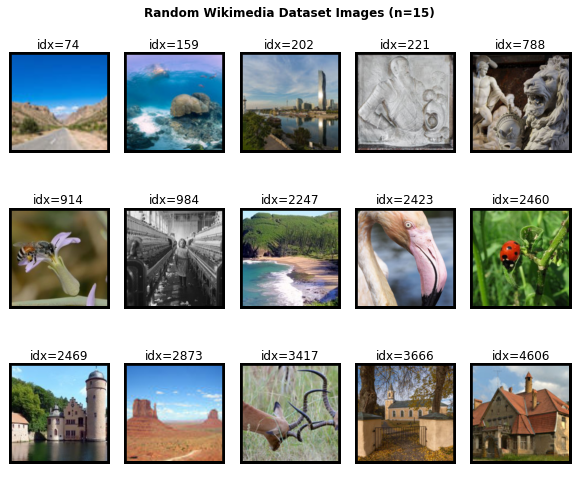

In [ ]:
n_items = 15
columns = 5

title = "Random Wikimedia Dataset Images\n"

selected_indices = random.choices(list(range(len(data['images']))), k=n_items)
# items = [(idx, to_std_size(data['images'][idx])) for idx in sorted(selected_indices)]
items_to_display = [{
    'title': f'idx={idx}',
    'image': to_std_size(data['images'][idx])
    } for idx in sorted(selected_indices)]

display_images({"Random Wikimedia Dataset Images": items_to_display}, columns=columns)

# Feature Extraction

We define a class **FeatureExtractor** which will allow us to utilize pretrained models to obtain visual features from input images 

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self, base_model, output_layer, requires_grad=True):
        super().__init__()
        self.output_layer = output_layer
        self.pretrained = base_model(pretrained=True)
        self.children_list = []
        for n, c in self.pretrained.named_children():
            self.children_list.append(c)
            if n == self.output_layer:
                break

        self.net = nn.Sequential(*self.children_list)
        for param in self.net.parameters():
            param.requires_grad = requires_grad

        self.pretrained = None
        
    def forward(self,x):
        x = self.net(x)
        return x

The following code will allow us to get crops from images to visualize them

In [ ]:
# Mean and std deviation from images in the Imagenet dataset
mean_pixel = [0.485, 0.456, 0.406]
std_pixel = [0.229, 0.224, 0.225]

normalize_image = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_pixel, std=std_pixel)
])

## AlexNet

Let's start with the initial Deep Convolutional Neural Network, the AlexNet. 

> Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). Imagenet classification with deep convolutional neural networks. Advances in neural information processing systems, 25, 1097-1105.



Remember  that this was the first Deep CNN who produced a large gain in performance in the ImageNet challenge in 2012. 

In [ ]:
# Load the pretrained model with this simple code!

models.alexnet()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# this block downloads a checkpoint of AlexNet from pytorch

model = FeatureExtractor(models.alexnet, 'avgpool', requires_grad=False)
model = model.cuda()

# we use model.eval() to prevent "training" mode
model.eval()
for image in tqdm(data['images']):
    normalized_image = normalize_image(image).unsqueeze(dim=0)
    normalized_image = normalized_image.cuda()
    features = model(normalized_image)
    features = F.adaptive_avg_pool2d(features, output_size=1) if len(features.shape) > 2 else features
    features = features.cpu()
    data['alexnet_features'].append(features)

data['alexnet_features'] = torch.cat(data['alexnet_features'])
data['alexnet_features'] = data['alexnet_features'].squeeze()

model = normalized_image = features = None

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


# Display Similar Images based on DNN Visual Features


So far we have our images' visual features. What's next? We can use these features to identify similar images. The following method will allow us:

*   To find the *k* most similar images to an input image *query*: **topk_similar**(query, knowledge_base, k=10)


We will use this function for the already instanced feature extractor (AlexNet), but we will also use it for the other methods (VGG, ResNet, NASNet)

In [ ]:
def topk_similar(query, knowledge_base, k=10):
    k = k + 1 # Remove self similarity
    distances = 1 - F.cosine_similarity(knowledge_base, query)
    topk = distances.topk(k, largest=False)
    indices = topk.indices.tolist()
    distances = topk.values.tolist()

    if len(indices) > 0:
        # Remove query item
        closest_distance = distances[0]
        indices = indices[1:] if math.isclose(closest_distance, 0.0) else indices
        distances = distances[1:] if math.isclose(closest_distance, 0.0) else distances

    return indices, distances

Let's play with it!

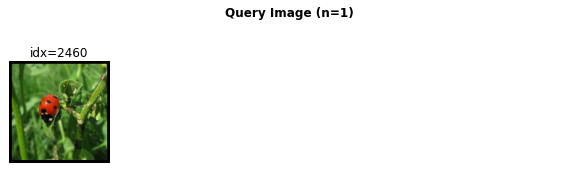

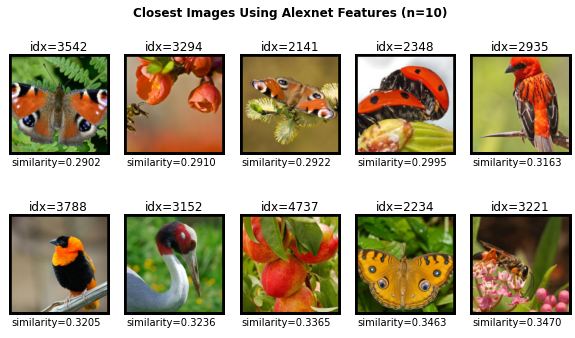

In [ ]:
#pick_randomly = True
#idx = random.randint(0, len(data['image_path'])) if pick_randomly else idx


idx = 2460

features_id = 'alexnet_features'
features = data[features_id][idx, :].unsqueeze(0)

image = to_std_size(data['images'][idx])

closest_indices, closest_distances = topk_similar( features, data[features_id], k=10 )
closest_images = [{
    'title': f'idx={idx_}',
    'image': to_std_size(data['images'][idx_]),
    'subtitle': f'similarity={distance:.4f}'
    } for idx_, distance in zip(closest_indices, closest_distances)]

display_images({
    'Query Image': [{
        'title': f'idx={idx}',
        'image': image
        }],
    f'Closest Images using AlexNet features': closest_images
}, columns=5)

Let's try this code with other Deep CNNs! VGG_16, ResNet_18 and NASNet. 

## VGG16

The VGG architecture was able to train deeper networks by using smaller filter (notice differences in kernel size with Alexnet)

> Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556


In [ ]:
models.vgg16()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# this block downloads a checkpoint of VGG-16 from pytorch

model = FeatureExtractor(models.vgg16, 'avgpool', requires_grad=False)
model = model.cuda()
    
model.eval()
for image in tqdm(data['images']):
    normalized_image = normalize_image(image).unsqueeze(dim=0)
    normalized_image = normalized_image.cuda()
    features = model(normalized_image)
    features = F.adaptive_avg_pool2d(features, output_size=1) if len(features.shape) > 2 else features
    features = features.cpu()
    data['vgg16_features'].append(features)

data['vgg16_features'] = torch.cat(data['vgg16_features'])
data['vgg16_features'] = data['vgg16_features'].squeeze()

model = normalized_image = features = None

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


## ResNet18

ResNet introduces residual connections, what reduces number of parameters and allows to increase network depth

> He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).



In [ ]:
models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# this block downloads a checkpoint of ResNet-18 from pytorch

model = FeatureExtractor(models.resnet18, 'avgpool', requires_grad=False)
model = model.cuda()    

model.eval()
for image in tqdm(data['images']):
    normalized_image = normalize_image(image).unsqueeze(dim=0)
    normalized_image = normalized_image.cuda()
    features = model(normalized_image)
    features = F.adaptive_avg_pool2d(features, output_size=1) if len(features.shape) > 2 else features # Reduce feature cube to 1-d
    features = features.cpu()
    data['resnet18_features'].append(features)

data['resnet18_features'] = torch.cat(data['resnet18_features'])
data['resnet18_features'] = data['resnet18_features'].squeeze()

model = normalized_image = features = None

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


## MNASNet

In NASNet (Network Architecture Search Networks) the global architure is fixed but blocks or cells are not predefined by authors. Instead, they are searched by reinforcement learning search.

> Zoph, B., Vasudevan, V., Shlens, J., & Le, Q. V. (2018). Learning transferable architectures for scalable image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 8697-8710).

MNASNet is the version available in Pytorch, where "M" is for Mobile


> Tan, M., Chen, B., Pang, R., Vasudevan, V., Sandler, M., Howard, A., & Le, Q. V. (2019). Mnasnet: Platform-aware neural architecture search for mobile. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 2820-2828).



In [ ]:
models.mnasnet1_0()

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

In [ ]:
# this block downloads a checkpoint of NASNet from pytorch

model = FeatureExtractor(models.mnasnet1_0, 'layers', requires_grad=False)
model = model.cuda()
    
model.eval()
for image in tqdm(data['images']):
    normalized_image = normalize_image(image).unsqueeze(dim=0)
    normalized_image = normalized_image.cuda()
    features = model(normalized_image)
    features = F.adaptive_avg_pool2d(features, output_size=1) if len(features.shape) > 2 else features
    features = features.cpu()
    data['mnasnet_features'].append(features)

data['mnasnet_features'] = torch.cat(data['mnasnet_features'])
data['mnasnet_features'] = data['mnasnet_features'].squeeze()

model = normalized_image = features = None

Downloading: "https://download.pytorch.org/models/mnasnet1.0_top1_73.512-f206786ef8.pth" to /root/.cache/torch/hub/checkpoints/mnasnet1.0_top1_73.512-f206786ef8.pth


## Closest Examples

In [ ]:
idx =  596#@param {type:"integer"}
pick_randomly = False #@param {type:"boolean"}
features_to_compare = "resnet18" #@param ["", "alexnet", "vgg16", "resnet18", "mnasnet"]
k_closest = 10 #@param {type:"integer"}

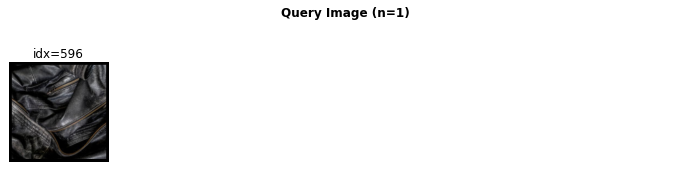

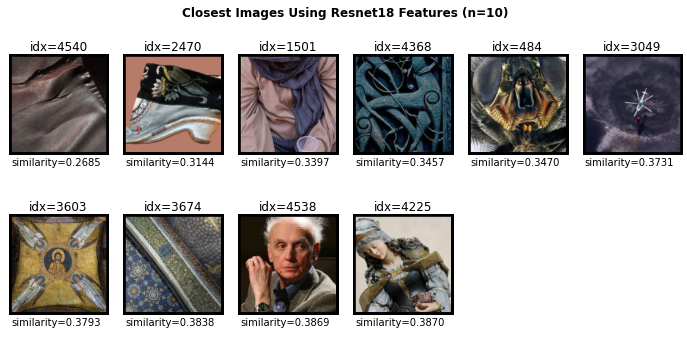

In [ ]:
idx = random.randint(0, len(data['image_path'])) if pick_randomly else idx

features_to_compare = random.choice(
    ["alexnet", "vgg16", "resnet18", "mnasnet"]) if not features_to_compare else features_to_compare
features_id = f'{features_to_compare}_features'
features = data[features_id][idx, :].unsqueeze(0)

image = to_std_size(data['images'][idx])

closest_indices, closest_distances = topk_similar(features, data[features_id], k=k_closest)
closest_images = [{
    'title': f'idx={idx_}',
    'image': to_std_size(data['images'][idx_]),
    'subtitle': f'similarity={distance:.4f}'
    } for idx_, distance in zip(closest_indices, closest_distances)]

display_images({
    'Query Image': [{
        'title': f'idx={idx}',
        'image': image
        }],
    f'Closest Images using {features_to_compare} features': closest_images
}, columns=6)

## Missing aspects

**How to store and use this for a recommendation system?**

We can save the visual features as a numpy file and load it in another script or notebook. We will talk about that next.